In [1]:
import time 
import numpy as np
import pandas as pd
import pylab as pl
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [2]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: None
PATH: C:\Users\cgzog\anaconda3\envs\PySDR;C:\Users\cgzog\anaconda3\envs\PySDR\Library\mingw-w64\bin;C:\Users\cgzog\anaconda3\envs\PySDR\Library\usr\bin;C:\Users\cgzog\anaconda3\envs\PySDR\Library\bin;C:\Users\cgzog\anaconda3\envs\PySDR\Scripts;C:\Users\cgzog\anaconda3\envs\PySDR\bin;C:\Users\cgzog\anaconda3\condabin;C:\Users\cgzog\anaconda3;C:\Users\cgzog\anaconda3\Library\mingw-w64\bin;C:\Users\cgzog\anaconda3\Library\usr\bin;C:\Users\cgzog\anaconda3\Library\bin;C:\Users\cgzog\anaconda3\Scripts;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\MATLAB\R2022a\runtime\win64;C:\Program Files\MATLAB\R2022a\bin;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\dotnet;.;C:\WINDOWS\syste

In [3]:
def plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):
    n_fft = len(matchedFilter)
    f = np.arange(0,fs/2,fs/n_fft)
    w = np.hanning(len(matchedFilter))
    mf_freqDom = np.fft.fft(np.multiply(matchedFilter,w))
    mf_freqDom = 10*np.log10(np.abs(mf_freqDom[0:int(n_fft/2)]/n_fft))
    pl.subplot(3,1,1)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],m[0:int(fs*bitsPerWord*minbit)])
    pl.xlabel("Time (s)")
    pl.ylabel("Frequency (Hz)")
    pl.title("Original VCO output verus time")
    pl.grid = True
    pl.subplot(3,1,2)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],matchedFilter[0:int(fs*bitsPerWord*minbit)])
    pl.xlabel("Time (s)")
    pl.ylabel("Amplitude (V)")
    pl.title("Original of carrier verus time")
    pl.grid = True
    pl.subplot(3,1,3)
    pl.plot(f[0:int((fc+fdev*2)*n_fft/fs)],matchedFilter[0:int((fc+fdev*2)*n_fft/fs)])
    pl.xlabel("Frequency (Hz)")
    pl.ylabel("Amplitude (dB)")
    pl.title("Spectrum")
    pl.grid = True
    pl.tight_layout()
    pl.show
    
def plot_spectral(fft_size, signal, fs):
    print(signal.shape)
    num_rows = int(np.floor(len(signal)/fft_size))
    spectrogram = np.zeros((num_rows, fft_size))
    for i in range(num_rows):
        spectrogram[i,:] = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal[i*fft_size:(i+1)*fft_size])))**2)
    spectrogram = spectrogram[:,fft_size//2:] # get rid of negative freqs because we simulated a real signal
    plt.imshow(spectrogram, aspect='auto', extent = [0, fs/2/1e6, len(signal)/fs, 0])
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Time [s]")
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    plt.show()
    #plt.savefig('../_images/spectrogram.svg', bbox_inches='tight')

In [8]:
def noise_spectrum(lowRF, highRF, numSamples):
    noiseCarrierFreqs = np.random.uniform(low=lowRF, high=highRF, size=numSamples)
    return noiseCarrierFreqs

def make_pulse_train(train, matchedFilter, pw, pri, fs, lowRF, highRF, noiseAmp):
    interpTime = pri-pw
    noiseCarrierFreqs = noise_spectrum(lowRF, highRF, int(interpTime/(1/fs)))
    pads = noiseAmp*np.random.random(size=int(interpTime/(1/fs)))*np.exp(1j*2*np.pi*noiseCarrierFreqs*int(interpTime/(1/fs)))
    mfNoise = np.random.random(size=len(matchedFilter))*noiseAmp
    matchedFilter += mfNoise
    matchedFilter = matchedFilter - np.mean(matchedFilter) # removes DC componenet introduced by adding noise, while preserving noise on pulses
    train_add = np.hstack((matchedFilter, pads.real))
    new_train = np.hstack((train, train_add))
    return new_train

def upsample(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out
    
def make_FM_pulse(A, fc, cr, t):
    fmPulse = A*np.exp(1j*np.pi*cr*t*t)*np.exp(1j*2*np.pi*fc*t)
    return fmPulse

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(np.arange(0,len(sync))*1/fs+np.pi*sync)))
    return bpskPulse

def make_FSK_pulse(A,code,minbit,fs,fc,fdev,ctrlBit):
    sync = upsample(code, fs*minbit)
    t = np.arange(0,len(sync))*1/fs
    m = []
    for bit in sync:
        if bit == ctrlBit:
            m = np.hstack((m, (fc-fdev)))
        else:
            m = np.hstack((m, (fc+fdev)))              
    fskPulse = A*np.exp(1j*(2*np.pi*np.multiply(m,t)))
    return fskPulse                

In [5]:
def simulate_signal(pulse_length=100, data_length=1000, pri=10, snr=1/1000):
    pulse_length = int(pulse_length)
    data_length = int(data_length)
    pri = int(pri)
    pulse = np.random.normal(size=pulse_length)
    data=np.zeros(data_length)
    pulse_index = 0
    while pulse_index*pri < data_length:
        start_data = pulse_index*pri
        end_data = pulse_index*pri + pulse_length
        end_pulse = data_length - pulse_index*pri
        data[start_data:end_data] = pulse[:end_pulse]
        pulse_index += 1
    print("{} pulses inserted.".format(pulse_index))
    sig_var = np.var(pulse)
    snr = 1/3000
    factor = np.sqrt(sig_var/snr)
    noise = factor * np.random.normal(size=data.shape[0])
    data += noise
    print(data.shape)
    data = data / np.abs(data).max() * 128
    return data

# Generate PSK Pulse Train

In [11]:
words = pd.read_csv("allPossible8bitWords.csv",dtype=str)      
randCodes = words.sample(n=10)
pri = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,]
rf = [20e6,20e6,20e6,20e6,20e6,20e6,20e6,20e6,20e6,20e6]
bitrate = 8e6
pw = [8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate,8/bitrate]

randCodes.Code
m = []
for code in randCodes.Code:
    m.append(code)
    
df = pd.DataFrame({"PD (usec)": pw, "PRI (usec)": pri, "RF (MHz)": rf, "Code": m}).to_csv("pulseTrainTest.csv")

In [6]:
test = pd.read_csv("pulseTrainTest.csv",dtype={"Code":str})
pdArray =  test["PD (usec)"]
priArray = test["PRI (usec)"]
RF = test["RF (MHz)"]
#test = pd.read_csv("pulseTrainTest.csv",dtype=str)
code = test["Code"]

In [9]:
A = 100
pd_idx = np.arange(0,len(pdArray))
start = time.time()
idx = 0
fs = 50e6
noiseAmp = 125
bitrate = 8e6
lowRF = 1e6
highRF = 5e6
while idx < test.shape[0]:
    pw = pdArray[idx]
    fc = RF[idx]
    t = np.arange(-pw/2, pw/2, 1/fs)
    pulse = make_BPSK_pulse(A, code[idx], fs, fc, 1/bitrate)  # decide later
    pri = priArray[idx]
    if idx == 0:
        train = make_pulse_train([], pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    if idx > 0:
        train = make_pulse_train(train, pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    idx += 1
signal=train

(500000,)


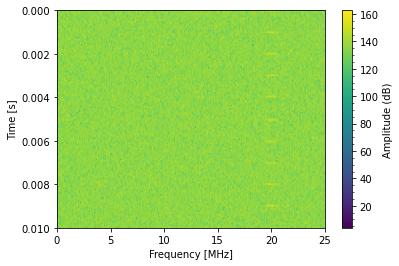

In [10]:
plot_spectral(2**12, train, fs)